In [106]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision,Recall,CategoricalAccuracy
import matplotlib.pyplot as plt
import pickle
import json
import os

In [107]:
os.chdir("/tf-acno-projects/image-classification")

In [108]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
tf.config.optimizer.set_jit(True)  # Enable XLA
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)]  # Limit GPU memory usage
            )
            print(f"Memory limit set for GPU")
    except RuntimeError as e:
        print(e)
        
# Before training
print("\nXLA Status Check:")
print(f"XLA JIT enabled: {tf.config.optimizer.get_jit()}")
print(f"XLA devices: {tf.config.list_logical_devices('XLA_GPU')}")

Memory limit set for GPU

XLA Status Check:
XLA JIT enabled: autoclustering
XLA devices: [LogicalDevice(name='/device:XLA_GPU:0', device_type='XLA_GPU')]


In [109]:
def plot_training_history(train_acc,val_acc,train_loss,val_loss):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, 'b-o', label='Training Accuracy')
    plt.plot(val_acc, 'r-o', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, 'b-o', label='Training Loss')
    plt.plot(val_loss, 'r-o', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

In [110]:
model_path = 'models/1_2024_12_5_0.912.keras'

In [111]:
pretrained_model = tf.keras.models.load_model(model_path)

In [112]:
data_dir = 'faces_data'
autotune = tf.data.AUTOTUNE
img_size = (128,128,3)
batch_size = 32
learning_rate = 0.00005
MAX_IMAGES_USED = 1500

In [113]:
def prepare_dataset(is_training,dataset,batch_size,shuffle_buffer=None):
    dataset = dataset.map(
        lambda x,y: (tf.cast(x,tf.float32)/255.0,y),
        num_parallel_calls = autotune
    )
    
    if is_training:
#The shuffle buffer size controls how much data is loaded into memory for shuffling. 
# A smaller value will reduce memory usage and initialization time, but it might reduce shuffle quality.
        dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size)
    
    return dataset.prefetch(autotune)

#### filtering the dataset using MAX_IMAGES_USED

In [114]:
tf.keras.backend.clear_session()
original_dataset = image_dataset_from_directory(
    data_dir,
    image_size=(128,128),
    label_mode='categorical',# Ensure labels are one-hot encoded
    batch_size= batch_size,
)
# Collect images and labels
all_images = []
all_labels = []
class_counts = {}
for images, labels in original_dataset:
    labels_np = labels.numpy()
    for i in range (len(images)):
        label_int = int(tf.argmax(labels_np[i]))
        if class_counts.get(label_int, 0) < MAX_IMAGES_USED:
            all_images.append(images[i])
            all_labels.append(labels_np[i])
            class_counts[label_int] = class_counts.get(label_int, 0) + 1
# Print class distribution
print("Class counts:", class_counts)
# Convert to tensor dataset
all_images = tf.stack(all_images)
all_labels = tf.stack(all_labels)  # Ensure labels are integers
dataset = tf.data.Dataset.from_tensor_slices((all_images, all_labels))

Found 11107 files belonging to 5 classes.
Class counts: {0: 1500, 4: 1500, 3: 1500, 1: 1500, 2: 1500}


In [115]:
for i,class_name in enumerate(original_dataset.class_names):
    print(f"class {i} : label : {class_name}\n")

class 0 : label : angry

class 1 : label : disgusted

class 2 : label : happy

class 3 : label : sad

class 4 : label : shocked



In [116]:
train_size = int(0.8* len(all_images))
val_size = int(0.1 * len(all_images))
# Split the dataset
training_split = dataset.take(train_size)
remaining = dataset.skip(train_size)

validation_split = remaining.take(val_size)
testing_split = remaining.skip(val_size)


In [117]:
callbacks = [
    EarlyStopping(monitor='val_loss',patience=25,min_delta=0.0001,restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss",factor=0.5, patience=10,min_delta=0.001,min_lr=1e-6),
]

In [118]:
train_dataset = prepare_dataset(True,training_split,batch_size,2500) # Shuffle buffer size	with 7500/3 = 2500 
test_dataset = prepare_dataset(False,testing_split,batch_size)
validation_dataset = prepare_dataset(False,validation_split,batch_size)

for image,_ in train_dataset.take(1):
    input_example = image.numpy()

In [119]:
pretrained_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss = CategoricalCrossentropy(),
    metrics = [Precision(),Recall(),CategoricalAccuracy()]
)

In [120]:
training_history = pretrained_model.fit(
    train_dataset,
    epochs=150,
    callbacks= callbacks,
    validation_data=validation_dataset,
    verbose=1
)

Epoch 1/150
188/188 [==============================] - 16s 26ms/step - loss: 4.5661 - precision: 0.5622 - recall: 0.5040 - categorical_accuracy: 0.5317 - val_loss: 2.9736 - val_precision: 0.5830 - val_recall: 0.5107 - val_categorical_accuracy: 0.5520 - lr: 5.0000e-05
Epoch 2/150
188/188 [==============================] - 7s 34ms/step - loss: 2.7378 - precision: 0.5857 - recall: 0.4453 - categorical_accuracy: 0.5123 - val_loss: 1.9580 - val_precision: 0.6435 - val_recall: 0.4693 - val_categorical_accuracy: 0.5467 - lr: 5.0000e-05
Epoch 3/150
188/188 [==============================] - 3s 16ms/step - loss: 2.0599 - precision: 0.6068 - recall: 0.3593 - categorical_accuracy: 0.4763 - val_loss: 1.6426 - val_precision: 0.6464 - val_recall: 0.3827 - val_categorical_accuracy: 0.5200 - lr: 5.0000e-05
Epoch 4/150
188/188 [==============================] - 3s 15ms/step - loss: 1.7429 - precision: 0.6451 - recall: 0.3138 - categorical_accuracy: 0.4638 - val_loss: 1.5227 - val_precision: 0.7046 - va

In [121]:
train_accuracy = training_history.history['categorical_accuracy'][-1]  # Last epoch's training accuracy
val_accuracy = training_history.history['val_categorical_accuracy'][-1]  # Last epoch's validation accuracy

# If Precision and Recall are included in the metrics
train_precision = training_history.history['precision'][-1]
val_precision = training_history.history['val_precision'][-1]

train_recall = training_history.history['recall'][-1]
val_recall = training_history.history['val_recall'][-1]

train_loss = training_history.history['loss'][-1]
val_loss = training_history.history['val_loss'][-1]

# Print the results
print(f"Training Accuracy: {train_accuracy:.2f}, Validation Accuracy: {val_accuracy:.2f}")
print(f"Training Precision: {train_precision:.2f}, Validation Precision: {val_precision:.2f}")
print(f"Training Recall: {train_recall:.2f}, Validation Recall: {val_recall:.2f}")
print(f"Training Loss: {train_loss:.2f}, Validation Loss: {val_loss:.2f}")

Training Accuracy: 0.65, Validation Accuracy: 0.59
Training Precision: 0.87, Validation Precision: 0.73
Training Recall: 0.51, Validation Recall: 0.47
Training Loss: 0.86, Validation Loss: 1.29


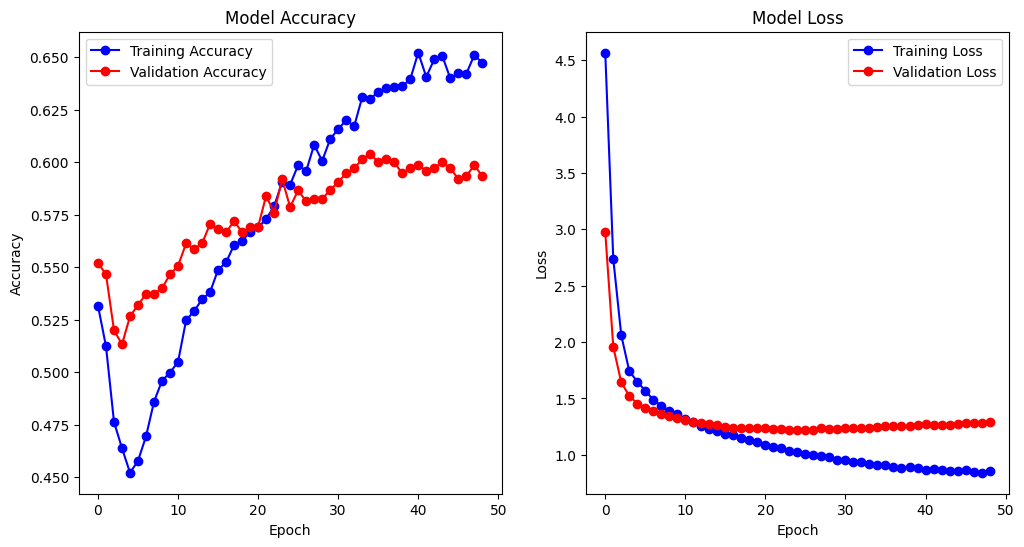

In [122]:
plot_training_history(
    training_history.history['categorical_accuracy'],
    training_history.history['val_categorical_accuracy'],
    training_history.history['loss'],
    training_history.history['val_loss']
                      )

In [123]:
results = pretrained_model.evaluate(test_dataset)
metric_names = pretrained_model.metrics_names  # Get metric names
results_dict = dict(zip(metric_names, results))  # Create a dictionary

print(results_dict)

24/24 [==============================] - 5s 47ms/step - loss: 0.8783 - precision: 0.8982 - recall: 0.6000 - categorical_accuracy: 0.7453
{'loss': 0.878342866897583, 'precision': 0.8982036113739014, 'recall': 0.6000000238418579, 'categorical_accuracy': 0.7453333139419556}


# Model Performance Results

## Initial Model (Old)
- **Validation Metrics**
    - Accuracy: 0.9397
    - Loss: 0.1974
- **Training Metrics**
    - Accuracy: 0.8877
    - Loss: 0.2755
- **Final Test Results**
    - Accuracy: 0.9246
    - Loss: 0.2040

---

In [124]:
from datetime import datetime
timestamp = datetime.now().strftime("%d_%m_%Y_%HH_%M")

In [125]:
# Check if 'categorical_accuracy' exists and is a float
if 'categorical_accuracy' in results_dict and isinstance(results_dict['categorical_accuracy'], (float, int)):
    model_save_path = f"models/re_trained_{timestamp}_{results_dict['categorical_accuracy']:.3f}.keras"
    print(f"Model will be saved to: {model_save_path}")
else:
    print("Error: 'categorical_accuracy' key is missing or its value is not a float.")

Model will be saved to: models/re_trained_07_02_2025_19H_26_0.745.keras


In [126]:
pretrained_model.save(model_save_path)

In [127]:
params = {
        "img_size": img_size,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "MAX_IMAGES_USED": MAX_IMAGES_USED,
}

metrics = {
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_loss': train_loss,

        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_loss': val_loss,

        'test_accuracy': results_dict['categorical_accuracy'],
        'test_loss': results_dict['loss'],
}

model = {
        'model_architecture': pretrained_model,
        'model_name':'pre_trained_model',
}

In [128]:
params_path = 'mlflow_details/mlflow_params.json'
metrics_path = 'mlflow_details/mlflow_metrics.json'
model_path = 'mlflow_details/mlflow_model.pkl'
input_path = 'mlflow_details/mlflow_input_example.pkl'

with open(params_path, 'w') as f:
    json.dump(params, f)
    
with open(metrics_path, 'w') as f:
    json.dump(metrics, f)
    
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
    
with open(input_path, 'wb') as f:
    pickle.dump(input_example, f) 